In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip gdrive/My\ Drive/plantvillage.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/11030437-942c-4cb4-a40e-b35236778a4b___UF.GRC_YLCV_Lab 02923_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/1104914f-f715-4b02-b551-5cdf03f54bcb___YLCV_NREC 2717_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/11061195-ce9c-4171-819d-663342a186e8___YLCV_NREC 0257_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/110c50e6-039e-4f32-bda1-26262968ab8a___YLCV_GCREC 5539_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/1114e83e-5477-483c-8bed-847b2c169c9f___YLCV_NREC 2257_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/111d4096-e9eb-4f32-9a25-f3c19b92c627___YLCV_GCREC 2209_final_masked.jpg  
  in

In [5]:
pip install split-folders[full]

In [6]:
import splitfolders

In [7]:
input_file="plantvillage dataset/color"
output_file="plantvillage dataset splitted"

In [8]:
splitfolders.ratio(input_file, output=output_file, seed=42, ratio=(.7, .2, .1), group_prefix=None)

Copying files: 54305 files [00:35, 1539.65 files/s]


In [9]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [11]:
#Exploratory Data Aanalysis
len(os.listdir("/content/plantvillage dataset splitted/train"))

38

In [12]:
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [13]:
train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3, horizontal_flip=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
train=train_datagen.flow_from_directory(directory="/content/plantvillage dataset splitted/train",
                                target_size=(256,256),
                                batch_size=32)

val=val_datagen.flow_from_directory(directory="/content/plantvillage dataset splitted/val",
                                target_size=(256,256),
                                batch_size=32)

Found 37997 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [15]:
t_img, label= train.next()

In [16]:
t_img.shape

(32, 256, 256, 3)

In [17]:
def plotImage(img_arr, label):
  for im, l in zip(img_arr, label):
    plt.figure(figsize=(5,5))
    img_array = img_to_array(im)
    img_array /= 255.0
    plt.imshow(img_array)
    plt.show()

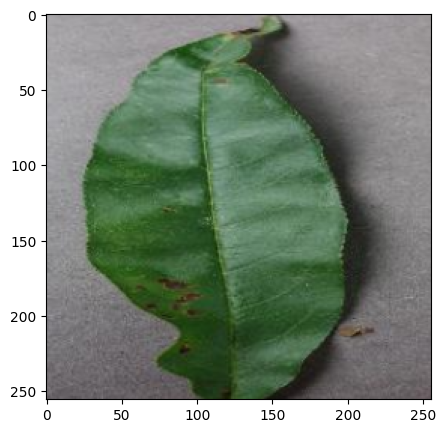

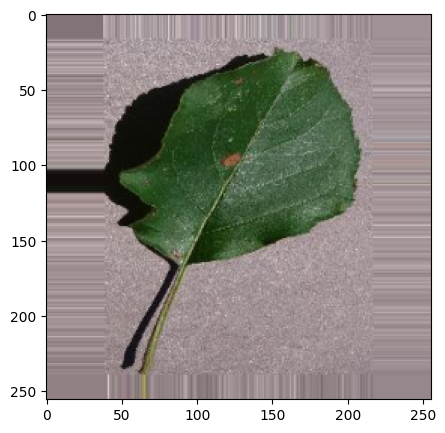

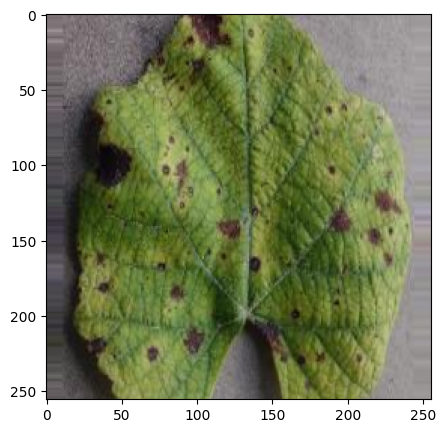

In [18]:
plotImage(t_img[:3], label[:3])

In [19]:
#BUILDING THE MODEL
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [20]:
base_model=VGG19(input_shape=(256,256,3), include_top=False)

80134624/80134624 [==============================] - 5s 0us/step


In [21]:
for layer in base_model.layers:
  layer.trainable=False

In [22]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [23]:
X=Flatten()(base_model.output)
X=Dense(units=38, activation='softmax')(X)

#CREATING THE MODEL
model=Model(base_model.input, X)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [25]:
#COMPILE THE MODEL
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [26]:
#EARLY STOPPING AND MODEL CHECKPOINT
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [27]:
#early stopping
es=EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)
#model checkpoint
mc=ModelCheckpoint(filepath='best_model.h5',monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1, save_best_only=True)

In [28]:
#add to array
cb=[es,mc]

In [29]:
his=model.fit_generator(train,steps_per_epoch=16, epochs=50, verbose=1, callbacks=cb, validation_data=val, validation_steps=16)

<ipython-input-29-bca262c48a05>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his=model.fit_generator(train,steps_per_epoch=16, epochs=50, verbose=1, callbacks=cb, validation_data=val, validation_steps=16)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 37.9078 - accuracy: 0.1953
Epoch 1: val_accuracy improved from -inf to 0.45312, saving model to best_model.h5
16/16 [==============================] - 34s 886ms/step - loss: 37.9078 - accuracy: 0.1953 - val_loss: 15.0223 - val_accuracy: 0.4531
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 19.0014 - accuracy: 0.5215
Epoch 2: val_accuracy improved from 0.45312 to 0.54102, saving model to best_model.h5
16/16 [==============================] - 15s 944ms/step - loss: 19.0014 - accuracy: 0.5215 - val_loss: 11.0721 - val_accuracy: 0.5410
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 13.5370 - accuracy: 0.5703
Epoch 3: val_accuracy improved from 0.54102 to 0.59570, saving model to best_model.h5
16/16 [==============================] - 12s 774ms/step - loss: 13.5370 - accuracy: 0.5703 - val_loss: 10.2674 - val_accuracy: 0.5957
Epoch 4/50
16/16 [==============================] - ETA: 0

In [30]:
#plot the model
h=his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

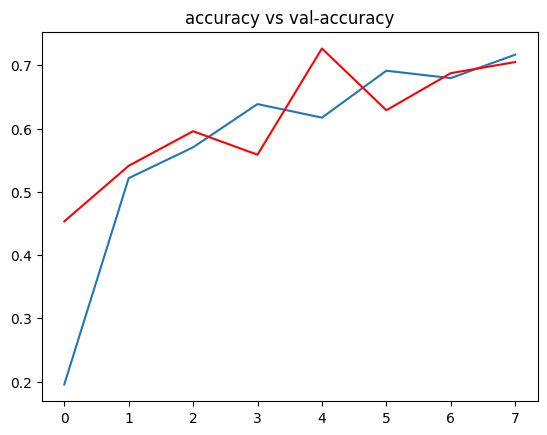

In [31]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")
plt.title("accuracy vs val-accuracy")
plt.show()

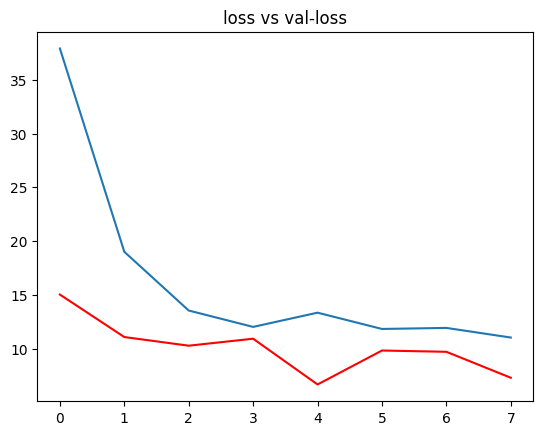

In [32]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='red')
plt.title("loss vs val-loss")
plt.show()

In [33]:
#LOAD THE BEST MODEL
from keras.models import load_model
model=load_model("/content/best_model.h5")

In [34]:
#EVALUATE THE MODEL
acc=model.evaluate_generator(val)[1]
print(f"The accuracy of the model is {acc*100}%")

<ipython-input-34-cab901df60aa>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc=model.evaluate_generator(val)[1]


The accuracy of the model is 68.90957951545715%


In [43]:
train.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [45]:
list(train.class_indices.keys())

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [46]:
list(train.class_indices.values()), list(train.class_indices.keys())

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37],
 ['Apple___Apple_scab',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  'Apple___healthy',
  'Blueberry___healthy',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___healthy',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn_(maize)___Common_rust_',
  'Corn_(maize)___Northern_Leaf_Blight',
  'Corn_(maize)___healthy',
  'Grape___Black_rot',
  'Grape___Esca_(Black_Measles)',
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
  'Grape___healthy',
  'Orange___Haunglongbing_(Citrus_greening)',
  'Peach___Bacterial_spot',
  'Peach___healthy',
  'Pepper,_bell___Bacterial_spot',
  'Pepper,_bell___healthy',
  'Potato___Early_blight',
  'Potato___Late_blight',
  'Potato___healthy',
  'Raspberry___healthy',
  'Soybean___healthy',
  'Squas

In [51]:
ref=dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))

In [52]:
#CHECK PREDICTIONS
def prediction(path):
  img=load_img(path, target_size=(256, 256))
  i = img_to_array(img)
  im=preprocess_input(i)
  img=np.expand_dims(im, axis=0)
  pred= np.argmax(model.predict(img))
  print(f"The image belongs to {ref[pred]}")

In [56]:
path="/content/plantvillage dataset splitted/test/Strawberry___Leaf_scorch/1081bac8-4ff2-4025-8328-446284666d47___RS_L.Scorch 1171.JPG"
prediction(path)

1/1 [==============================] - 0s 21ms/step
The image belongs to Strawberry___Leaf_scorch
